# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Ismail Masanja (200039322) - PG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os
import sys
from pprint import pprint

# Google Colab
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/INM460 Computer Vision Coursework'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# # Running Local
# GOOGLE_DRIVE_PATH = './'

pprint(os.listdir(GOOGLE_DRIVE_PATH))

['Report.docx',
 'Code.docx',
 'Code.pdf',
 'Video',
 'CW_Dataset',
 'Models',
 'Code',
 'model_training.ipynb',
 'test_functions.ipynb']


In [3]:
# Add code folder to path enviromental variable
sys.path.append(os.path.join(GOOGLE_DRIVE_PATH, 'Code'))

# Copy CW_Dataset to Colab Virtual machine for faster data loading.
dataset_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')

# Using Cached Dataset no need to copy data
# !cp -r '{dataset_path}' .

# Install dill to pickle more complex objects with lambdas
!pip install dill
!pip install facenet facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1

### Load packages

In the next cell you should load all the packages required to test your functions.

In [4]:
import cv2
import dill
import numpy as np
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import rc, rcParams
import matplotlib.animation as animation
rc('animation', html='jshtml')
# set animation limit
rcParams['animation.embed_limit'] = 150

from utils.data import CustomDataset, BalanceDataset, CachedDataset
from utils.helpers import calculate_sift_features, get_hist_idx, image_preprocess, Trainer
from utils.helpers import get_descriptors_labels as dsc
from utils.transforms import AddGaussianNoise
from utils.detectors import haar_cascade_detector, mtcnn_detector
from utils.loss import HingeLoss
from utils.vid_capture import ProcessVideo
from metrics.plot_distribution import plot_distribution
from metrics.calc_channel_mean_std import calc_channel_mean_std
from metrics.model_evaluator import ModelEvaluator
from metrics.show_rand_classification import random_classification
from metrics.show_rand_sample import show_rand_sample

from models import SIFTLinearSVM, SimpleVGGCNN

from utils.vid_capture import ProcessVideo

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

In [6]:
# Small utility function to simplify loading
def load_(obj_name, MODEL_SAVE_PATH=os.path.join(GOOGLE_DRIVE_PATH, 'Models')):
  OBJ_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, obj_name)
  # save load using dill module
  with open(OBJ_SAVE_PATH, 'rb') as file:
      loaded_obj = dill.load(file)
  return loaded_obj

def load_torch_model(obj_name, MODEL_SAVE_PATH=os.path.join(GOOGLE_DRIVE_PATH, 'Models')):
  OBJ_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, obj_name)
  device = "cuda" if torch.cuda.is_available() else "cpu"
  return torch.load(OBJ_SAVE_PATH, map_location=torch.device(device))

batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
# Labels Map
labels_map = {
    0: "No Face Mask",
    1: "Proper Wear",
    2: "Improper Wear",
}

# Load Transform
transform = load_('transform.pyclass')

# Load sift + svm model
sift_svm_model = load_torch_model('sift_svm.model')
sift_svm_model = sift_svm_model.to(device)

# Load simple VGG CNN model
simple_vgg_cnn = load_torch_model('simple_vgg_cnn.model')
simple_vgg_cnn = simple_vgg_cnn.to(device)

# Load mobilenet_v3_small model
mobilenet_v3_small = load_torch_model('mobilenet_v3_small.model')
mobilenet_v3_small = mobilenet_v3_small.to(device)


# Create a testing dataset and dataloader
test_dataset = CachedDataset(data_dir=os.path.join(dataset_path, 'test') , transform=transform)
balanced_test_dataset = BalanceDataset(test_dataset)

testing_data_loader =  DataLoader(balanced_test_dataset, batch_size=batch_size, shuffle=True)


# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [7]:
MaskDetection = random_classification

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

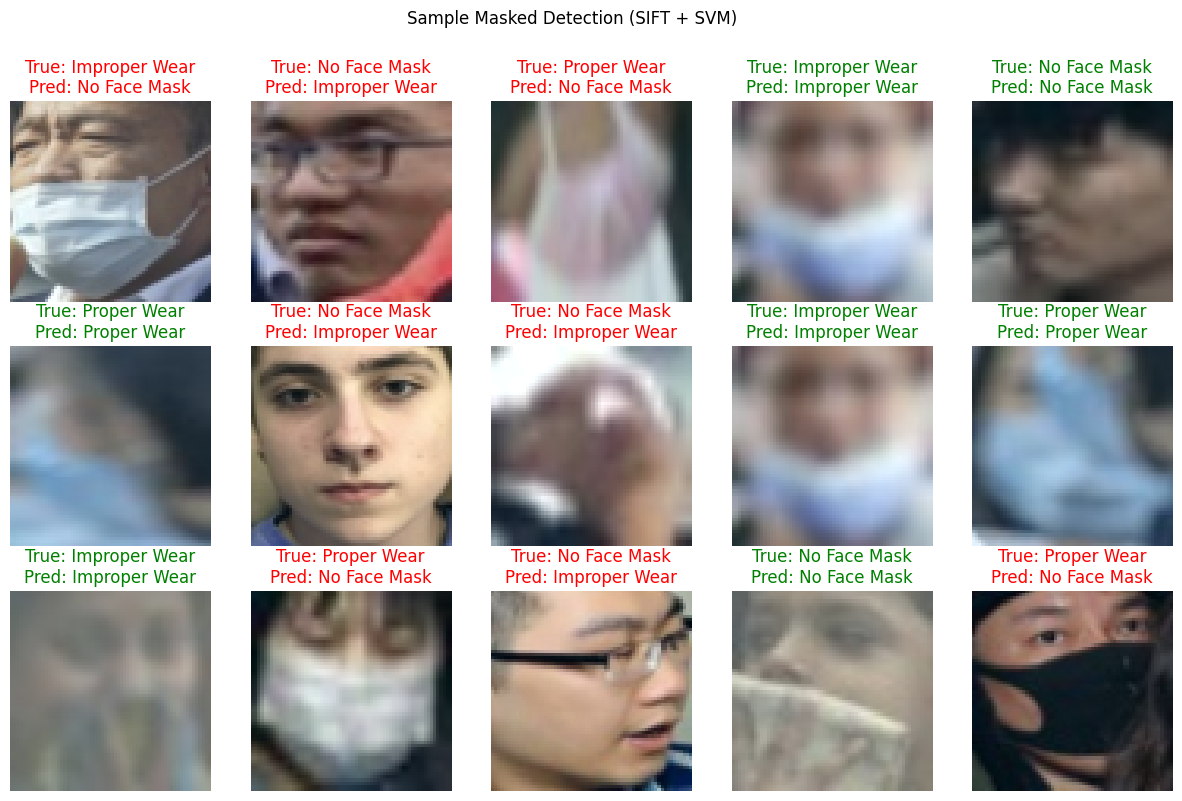

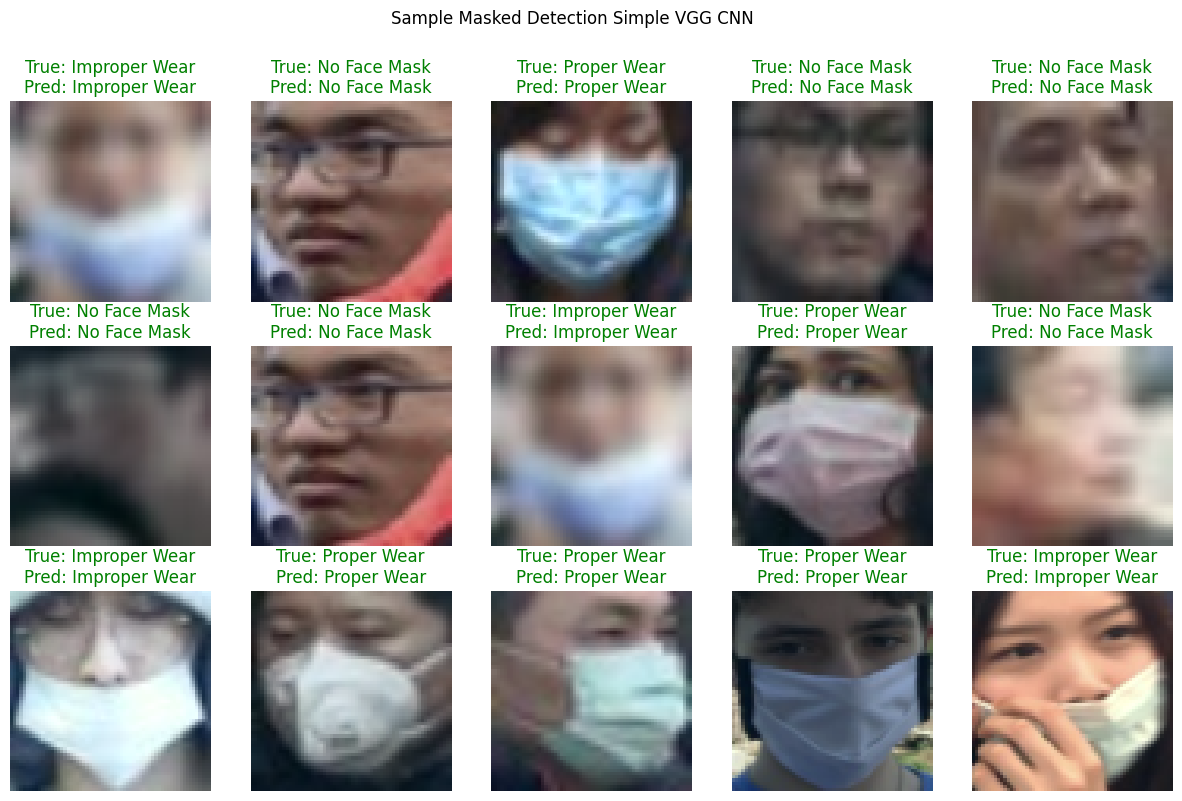

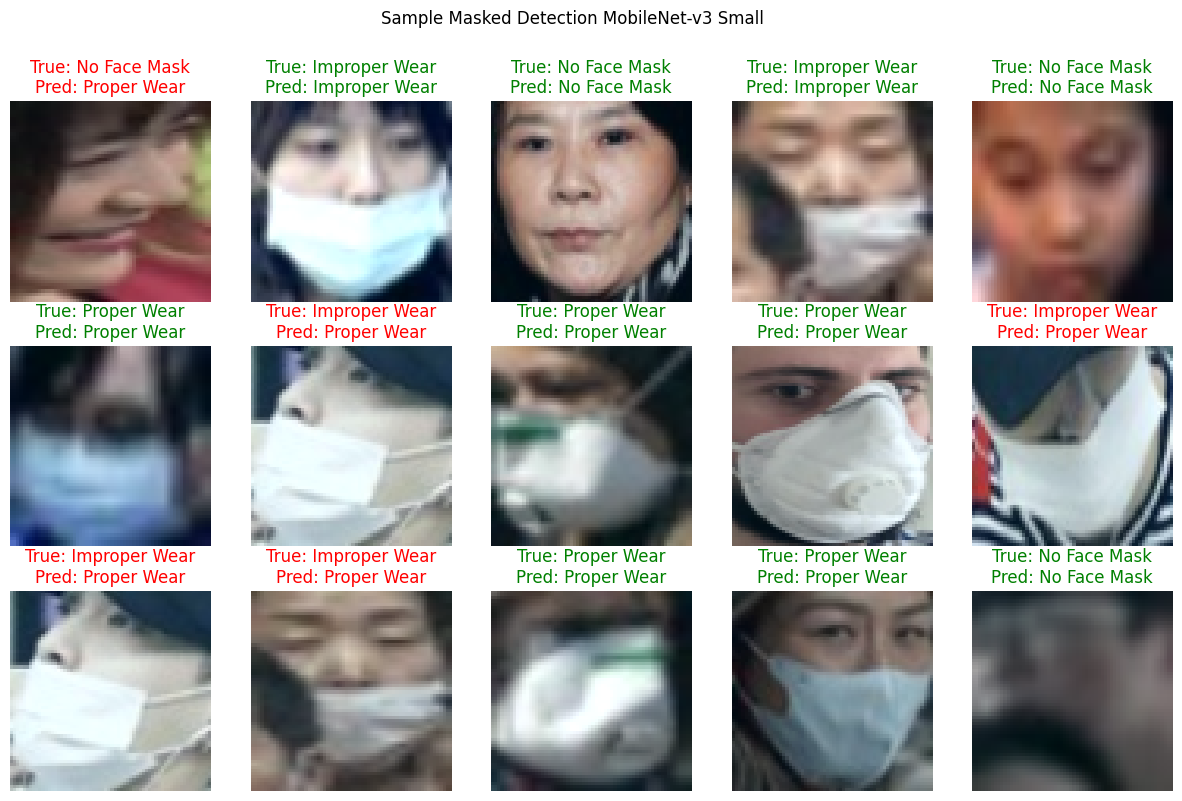

In [8]:
rows = 3
columns = 5

# SIFT + SVM Mask Detection
_ = MaskDetection(sift_svm_model, testing_data_loader, device, rows=rows, cols=columns,
                      title="Sample Masked Detection (SIFT + SVM)",
                      labels_map=labels_map)

# Simple VGG CNN Mask Detection
_ = MaskDetection(simple_vgg_cnn, testing_data_loader, device, rows=rows, cols=columns,
                      title="Sample Masked Detection Simple VGG CNN",
                      labels_map=labels_map)

# MobileNet-v3 Small Mask Detection
_ = MaskDetection(mobilenet_v3_small, testing_data_loader, device, rows=rows, cols=columns,
                      title="Sample Masked Detection MobileNet-v3 Small",
                      labels_map=labels_map)

Models performance metrics



Perfomance Metrics for SIFT + SVM
Metrics:
Accuracy: 0.3960
Precision: 0.3927
Recall: 0.3960
F1 Score: 0.3901

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.41      0.53      0.46       388
  Proper Wear       0.45      0.39      0.42       388
Improper Wear       0.33      0.27      0.29       388

     accuracy                           0.40      1164
    macro avg       0.39      0.40      0.39      1164
 weighted avg       0.39      0.40      0.39      1164



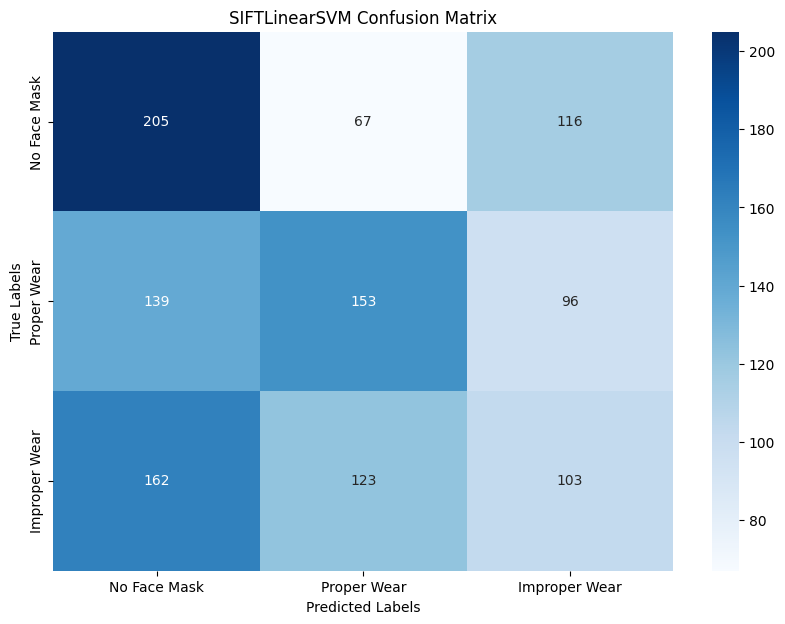



Perfomance Metrics for Simple VGG CNN
Metrics:
Accuracy: 0.7792
Precision: 0.8041
Recall: 0.7792
F1 Score: 0.7651

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.88      0.90      0.89       388
  Proper Wear       0.68      0.96      0.79       388
Improper Wear       0.86      0.47      0.61       388

     accuracy                           0.78      1164
    macro avg       0.80      0.78      0.77      1164
 weighted avg       0.80      0.78      0.77      1164



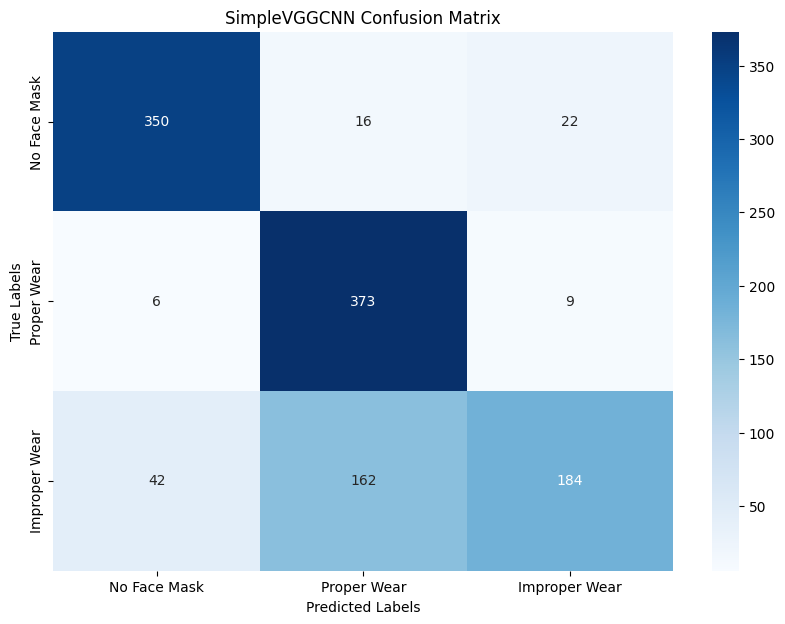



Perfomance Metrics for Mobilenet Version 3 Small
Metrics:
Accuracy: 0.7165
Precision: 0.7588
Recall: 0.7165
F1 Score: 0.6780

Classification Report:
                precision    recall  f1-score   support

 No Face Mask       0.89      0.90      0.89       388
  Proper Wear       0.60      0.98      0.74       388
Improper Wear       0.79      0.27      0.40       388

     accuracy                           0.72      1164
    macro avg       0.76      0.72      0.68      1164
 weighted avg       0.76      0.72      0.68      1164



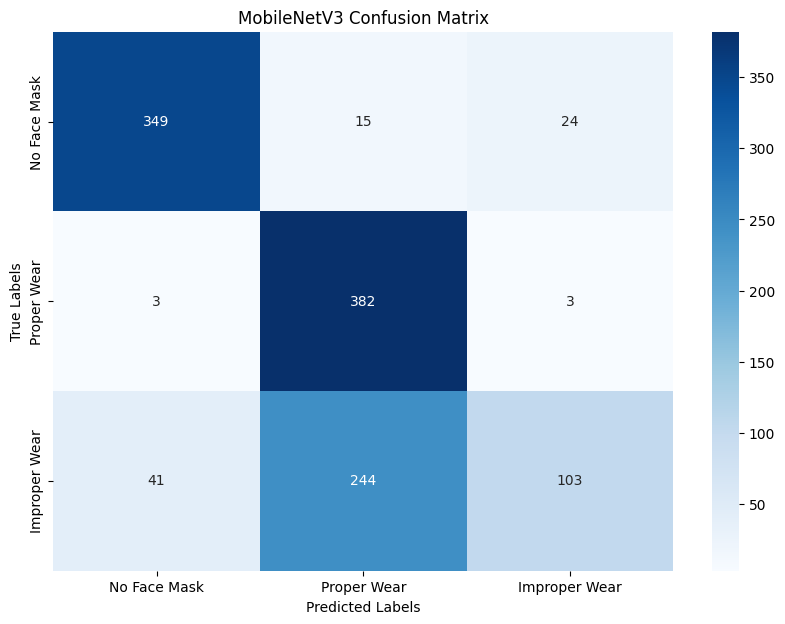

In [9]:
print(f'\n\nPerfomance Metrics for SIFT + SVM')
evaluator = ModelEvaluator(sift_svm_model, testing_data_loader, labels_map, device=device)
evaluator.evaluate()

print(f'\n\nPerfomance Metrics for Simple VGG CNN')
evaluator = ModelEvaluator(simple_vgg_cnn, testing_data_loader, labels_map, device=device)
evaluator.evaluate()

print(f'\n\nPerfomance Metrics for Mobilenet Version 3 Small')
evaluator = ModelEvaluator(mobilenet_v3_small, testing_data_loader, labels_map, device=device)
evaluator.evaluate()

# Test MaskDetectionVideo

This section should allow a quick test of the `MaskDetectionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetectionVideo` work.

In [10]:
# Detectors functions for drawing face bounding boxes
# haar from cv2
haar_cascade_detector = haar_cascade_detector

# mtcnn from facenet (more accurate)
mtcnn_detector = partial(mtcnn_detector, device) # partially pass the device variable to mtcnn

Then, make a call to the `MaskDetectionVideo` function to see what results it produces.

In [11]:
# initialize video capture object

# For Live Capture from Camera
# cap = cv2.VideoCapture(0)

# For video saved in video folder.
VIDEO_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Video', 'Cliped_Mask_Video.mp4')
cap = cv2.VideoCapture(VIDEO_PATH)

try:
  MaskDetectionVideo = ProcessVideo(cap, transform, labels_map, device, height=480, width=854)

  ## Live Capture ==> ( Press 'q' to quit ) <==
  # MaskDetectionVideo.live(mtcnn_detector, simple_vgg_cnn)

  # process offline video
  video = MaskDetectionVideo.offline(mtcnn_detector, simple_vgg_cnn)
finally:
  cap.release()
  cv2.destroyAllWindows()


print(f'Video Shape: {video.shape}')


Video Shape: (357, 480, 854, 3)


In [12]:

fig, ax = plt.subplots()
def frame(i):
    ax.clear()
    ax.axis('off')
    fig.tight_layout()
    plot=ax.imshow(video[i, :, :, :])
    return plot

anim = animation.FuncAnimation(fig, frame, frames=100)
plt.close()
anim

Output hidden; open in https://colab.research.google.com to view.